In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from typing import List, Optional
import matplotlib.pyplot as plt
from typing import Dict, Tuple

from package.processtransformer import constants
from package.processtransformer.models import transformer
from package.processtransformer.data.loader import LogsDataLoader
from package.processtransformer.data.processor import LogsDataProcessor
from package.processtransformer.constants import Task


# Initialize data dir, if not exists
if not os.path.exists("datasets"): 
    os.mkdir("datasets")

In [ ]:
b = []
c = "asdfasd"
a = f"{b if b else 'leer'}"
print(a)

# Task: Next Activity

In [20]:
class next_activity_pipeline:
    
    def __init__(self, dataset_name: str, filepath: str, columns: List[str], additional_columns: Optional[List[str]],
                 datetime_format: str, task: Task, model_learning_rate: float, model_epochs: int, model_num_layers: int):
        self.dataset_name: str = dataset_name
        self.filepath: str = filepath
        self.columns: List[str] = columns
        self.additional_columns: Optional[List[str]] = additional_columns
        self.datetime_format: str = datetime_format
        self.task: Task = task
        self.model_learning_rate: float = model_learning_rate
        self.model_epochs: int = model_epochs
        self.model_num_layers: int = model_num_layers
        
        self._preprocessing_id: str = f"{dataset_name}##{task.value}##{'#'.join(additional_columns) if additional_columns else 'No_Additional_Columns'}##"
        self._model_id: str = (
            f"{dataset_name}"
            f"##{'#'.join(self.columns)}"
            f"##{'#'.join(self.additional_columns)}"
            f"##{'#'.join(self.task.value)}"
            f"##{self.model_learning_rate}"
            f"##{self.model_epochs}"
            f"##{self.model_num_layers}")
        
        
    def __str__(self):
        return (
            f"dataset_name: '{self.dataset_name}'\n"
            f"filepath: '{self.filepath}'\n"
            f"columns: '{self.columns}'\n"
            f"additional_columns: '{self.additional_columns}'\n"
            f"datetime_format: '{self.datetime_format}'\n"
            f"task: '{self.task.value}'\n"
            f"Model learning rate: '{self.model_learning_rate}'\n"
            f"Model Epochs: '{self.model_epochs}'\n"
            f"Number of Transformer Layers in Model: '{self.model_num_layers}'\n")
        
    
    # preprocess the event log and save the train-test split as csv files
    def preprocess_log(self) -> List[int]:
        data_processor = LogsDataProcessor(
            name=self.dataset_name,
            filepath=self.filepath,
            preprocessing_id = self._preprocessing_id,
            columns=self.columns,
            additional_columns=self.additional_columns,  # Add all additional columns here, first all categorical, then all numerical features
            datetime_format=self.datetime_format,
            pool=4
        )
        # Preprocess the event log and make train-test split
        data_processor.process_logs(task=self.task, sort_temporally=False)
        
        # Compute the number of unique classes in each categorical column
        train_df = pd.read_csv(os.path.join("datasets", self.dataset_name, "processed", f"{self._preprocessing_id}_train.csv"))
        num_classes_list = data_processor._compute_num_classes(train_df)
        
        return num_classes_list
    
    
    # load the preprocessed train-test split from the csv files
    def load_data(self) -> Tuple [ LogsDataLoader, pd.DataFrame, pd.DataFrame, Dict[str, int], Dict[str, int], int, int, int ]:
        data_loader = LogsDataLoader(name=self.dataset_name, preprocessing_id=self._preprocessing_id)
        train_df, test_df, x_word_dict, y_word_dict, max_case_length, vocab_size, num_output = data_loader.load_data(self.task)
        return data_loader, train_df, test_df, x_word_dict, y_word_dict, max_case_length, vocab_size, num_output
    
    
    def prepare_data(self, data_loader, train_df, x_word_dict, y_word_dict, max_case_length, test_df):
        print("Preparing data for task next_activity...")
        # Prepare training examples for next activity prediction task
        train_token_x, train_token_y, train_additional_features, num_categorical_features, num_numerical_features = data_loader.prepare_data_next_activity(
            train_df, x_word_dict, y_word_dict, max_case_length, full_df=pd.concat([train_df, test_df])
        )
        return train_token_x, train_token_y, train_additional_features, num_categorical_features, num_numerical_features
    
    
    # Prepare data and train the model
    def train(self,
            num_categorical_features,
            num_numerical_features,
            train_additional_features,
            train_token_x,
            train_token_y,
            max_case_length: int,
            vocab_size: int,
            num_output: int,
            num_classes_list: List[int]
            ) -> tf.keras.Model:
        
        batch_size = 12
    
        # Define and compile the model
        model = transformer.get_next_activity_model(
            max_case_length=max_case_length,
            vocab_size=vocab_size,
            output_dim=num_output,
            num_categorical_features=num_categorical_features,
            num_numerical_features=num_numerical_features,
            num_classes_list=num_classes_list,  # Pass the computed number of classes list
            num_layers=self.model_num_layers
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(self.model_learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )

        # Train the model
        if train_additional_features.shape[1] == 0:
            history = model.fit([train_token_x], train_token_y, epochs=self.model_epochs, batch_size=batch_size)
        else:
            history = model.fit([train_token_x, train_additional_features], train_token_y, epochs=self.model_epochs, batch_size=batch_size)
            
        # Plot training loss
        self._plot_training_loss(history)
        return model
            
            
    def _plot_training_loss(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def evaluate(self, model, data_loader, train_df, test_df, max_case_length, x_word_dict, y_word_dict):
        print("Evaluating...")
        
        # Prepare lists to store evaluation metrics
        k, accuracies, fscores, precisions, recalls, weights = [], [], [], [], [], []

        # Calculate total number of samples
        total_samples = len(test_df)

        # Iterate over all prefixes (k)
        for i in range(max_case_length):
            print( "Prefix length: " + str(i) )
            test_data_subset = test_df[test_df["k"] == i]
            if len(test_data_subset) > 0:
                # Calculate weight for this prefix
                weight = len(test_data_subset) / total_samples
                
                # Prepare the test data
                test_token_x, test_token_y, test_additional_features, _, _ = data_loader.prepare_data_next_activity(
                    test_data_subset, x_word_dict, y_word_dict, max_case_length, full_df=pd.concat([train_df, test_df])
                )
                
                # Make predictions
                if test_additional_features.shape[1] != 0:
                    y_pred = np.argmax(model.predict([test_token_x, test_additional_features]), axis=1)
                else:
                    y_pred = np.argmax(model.predict([test_token_x]), axis=1)
                
                # Compute metrics
                accuracy = metrics.accuracy_score(test_token_y, y_pred)
                precision, recall, fscore, _ = metrics.precision_recall_fscore_support(test_token_y, y_pred, average="weighted", zero_division=0)
                
                # Store metrics and weight
                k.append(i)
                accuracies.append(accuracy)
                fscores.append(fscore)
                precisions.append(precision)
                recalls.append(recall)
                weights.append(weight)

        # Compute weighted mean metrics over all k
        weighted_accuracy = np.average(accuracies, weights=weights)
        weighted_fscore = np.average(fscores, weights=weights)
        weighted_precision = np.average(precisions, weights=weights)
        weighted_recall = np.average(recalls, weights=weights)

        # Append weighted mean metrics to the lists
        weights.append("")
        k.append("Weighted Mean")
        accuracies.append(weighted_accuracy)
        fscores.append(weighted_fscore)
        precisions.append(weighted_precision)
        recalls.append(weighted_recall)

        # Create a DataFrame to display the results
        results_df = pd.DataFrame({
            'k': k,
            'weight': weights,
            'accuracy': accuracies,
            'fscore': fscores,
            'precision': precisions,
            'recall': recalls
        })

        # Display the results
        print(results_df)

dataset_name: 'helpdesk'
filepath: 'helpdesk.csv'
columns: '['Case ID', 'Activity', 'Complete Timestamp']'
additional_columns: '['Resource']'
datetime_format: '%Y-%m-%d %H:%M:%S.%f'
task: 'next_activity'
Model learning rate: '0.001'
Model Epochs: '1'
Number of Transformer Layers in Model: '1'

Preprocessed train-test split for task next_activity found. Preprocessing skipped.
Loading data from preprocessed train-test split...
Preparing data for task next_activity...
Creating model for task next_activity...
1121/1121 [==============================] - 37s 26ms/step - loss: 0.8001 - sparse_categorical_accuracy: 0.7367


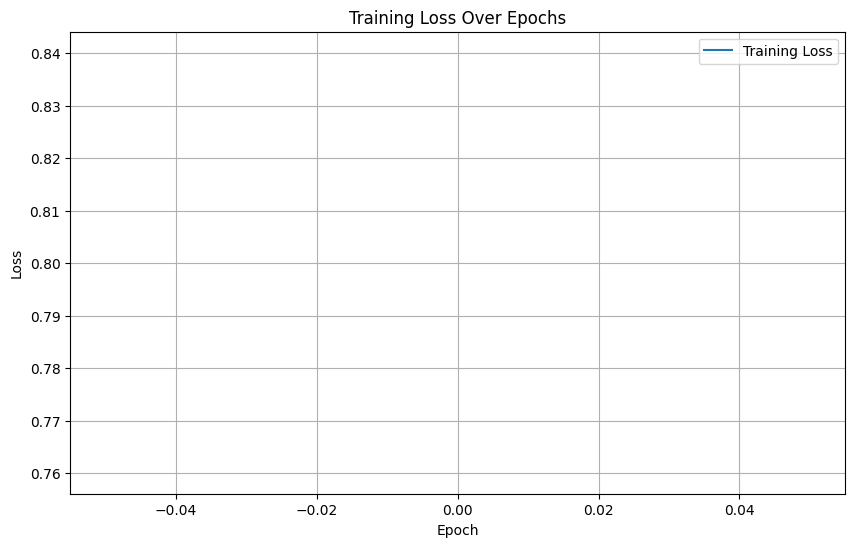

Evaluating...
Prefix length: 0
29/29 [==============================] - 2s 18ms/step
Prefix length: 1
29/29 [==============================] - 1s 15ms/step
Prefix length: 2
28/28 [==============================] - 1s 15ms/step
Prefix length: 3
12/12 [==============================] - 0s 16ms/step
Prefix length: 4
5/5 [==============================] - 0s 20ms/step
Prefix length: 5
3/3 [==============================] - 0s 21ms/step
Prefix length: 6
2/2 [==============================] - 0s 0s/step
Prefix length: 7
1/1 [==============================] - 0s 115ms/step
Prefix length: 8
1/1 [==============================] - 0s 92ms/step
Prefix length: 9
1/1 [==============================] - 0s 108ms/step
Prefix length: 10
1/1 [==============================] - 0s 115ms/step
Prefix length: 11
1/1 [==============================] - 0s 101ms/step
Prefix length: 12
Prefix length: 13
Sum Weights: 1.0
k: 13
weights: 13
accuracies: 13
fscores: 13
precisions: 13
recalls: 13
                k    

In [21]:
### Execution ###

# do only preprocessing on data
def preprocess(additional_columns):
    # initialize pipeline with parameters
    pipeline = next_activity_pipeline(
        dataset_name = "helpdesk",
        filepath = "helpdesk.csv",
        columns = ["Case ID", "Activity", "Complete Timestamp"],
        additional_columns = additional_columns,
        datetime_format = "%Y-%m-%d %H:%M:%S.%f",
        task = constants.Task.NEXT_ACTIVITY,
        model_learning_rate = 0.001,
        model_epochs = 0,
        model_num_layers = 1)
    # preprocess data
    pipeline.preprocess_log()


# for garbage collector - del variables for system speed
def run():

    # initialize pipeline with parameters
    pipeline = next_activity_pipeline(
        dataset_name = "helpdesk",
        filepath = "helpdesk.csv",
        columns = ["Case ID", "Activity", "Complete Timestamp"],
        additional_columns = ["Resource"],
        datetime_format = "%Y-%m-%d %H:%M:%S.%f",
        task = constants.Task.NEXT_ACTIVITY,
        model_learning_rate = 0.001,
        model_epochs = 1,
        model_num_layers = 1)

    # print parameters
    print(pipeline)

    # preprocess data
    num_classes_list = pipeline.preprocess_log()

    # load data
    data_loader, train_df, test_df, x_word_dict, y_word_dict, max_case_length, vocab_size, num_output = pipeline.load_data()

    # prepare data
    (train_token_x,
    train_token_y,
    train_additional_features,
    num_categorical_features,
    num_numerical_features ) = pipeline.prepare_data(data_loader, train_df, x_word_dict, y_word_dict, max_case_length, test_df)

    # train the model
    model = pipeline.train(
                num_categorical_features = num_categorical_features,
                num_numerical_features = num_numerical_features,
                train_additional_features = train_additional_features,
                train_token_x = train_token_x,
                train_token_y = train_token_y,
                max_case_length = max_case_length,
                vocab_size = vocab_size,
                num_output = num_output,
                num_classes_list = num_classes_list)

    # evaluate the model
    pipeline.evaluate(model, data_loader, train_df, test_df, max_case_length, x_word_dict, y_word_dict)
    

# for garbage collector - del variables for system speed
run()
# preprocess(additional_columns=["Resource"])
# preprocess(additional_columns=[])

## Preprocessing and Loading

### Helpdesk

In [ ]:
# Process and load data for the next activity task
dataset_name = "helpdesk"
data_loader, train_df, test_df, x_word_dict, y_word_dict, max_case_length, vocab_size, num_output, num_classes_list = process_and_load_data(
    dataset_name = dataset_name,
    filepath = "helpdesk.csv",
    columns = ["Case ID", "Activity", "Complete Timestamp"],
    additional_columns = ["Resource"],
    datetime_format = "%Y-%m-%d %H:%M:%S.%f",
    task = constants.Task.NEXT_ACTIVITY)

### Sepsis

In [ ]:
# Dataset processing
dataset_name = "sepsis"
data_processor = LogsDataProcessor(
    name=dataset_name,
    filepath="sepsis.xes",
    columns=["case:concept:name", "concept:name", "time:timestamp"],  # specify the columns name containing case_id, activity name and timestamp
    additional_columns=["org:group"],
    datetime_format="%Y-%m-%d %H:%M:%S%z",
    pool=4
)
data_processor.process_logs(task=constants.Task.NEXT_ACTIVITY, sort_temporally=False)

# Garbage collection
del data_processor

## Data Preparation for Training

In [ ]:
# Prepare training examples for next activity prediction task
train_token_x, train_token_y, train_additional_features, num_categorical_features, num_numerical_features = data_loader.prepare_data_next_activity(
    train_df, x_word_dict, y_word_dict, max_case_length, full_df=pd.concat([train_df, test_df])
)

# Garbage collection
del data_loader

## Model Training

In [ ]:
# Model parameters
learning_rate = 0.001
batch_size = 12
epochs = 3

# Define and compile the model
model = transformer.get_next_activity_model(
    max_case_length=max_case_length,
    vocab_size=vocab_size,
    output_dim=num_output,
    num_categorical_features=num_categorical_features,
    num_numerical_features=num_numerical_features,
    num_classes_list=num_classes_list,  # Pass the computed number of classes list
    num_layers=1
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train the model
if train_additional_features.shape[1] == 0:
    model.fit([train_token_x], train_token_y, epochs=epochs, batch_size=batch_size)
else:
    model.fit([train_token_x, train_additional_features], train_token_y, epochs=epochs, batch_size=batch_size)

## Evaluation

In [ ]:
# Prepare lists to store evaluation metrics
k, accuracies, fscores, precisions, recalls, weights = [], [], [], [], [], []

# Calculate total number of samples
total_samples = len(test_df)

# Iterate over all prefixes (k)
for i in range(max_case_length):
    test_data_subset = test_df[test_df["k"] == i]
    if len(test_data_subset) > 0:
        # Calculate weight for this prefix
        weight = len(test_data_subset) / total_samples
        
        # Prepare the test data
        test_token_x, test_token_y, test_additional_features, _, _ = data_loader.prepare_data_next_activity(
            test_data_subset, x_word_dict, y_word_dict, max_case_length, full_df=pd.concat([train_df, test_df])
        )
        
        # Make predictions
        if test_additional_features.shape[1] != 0:
            y_pred = np.argmax(model.predict([test_token_x, test_additional_features]), axis=1)
        else:
            y_pred = np.argmax(model.predict([test_token_x]), axis=1)
        
        # Compute metrics
        accuracy = metrics.accuracy_score(test_token_y, y_pred)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(test_token_y, y_pred, average="weighted")
        
        # Store metrics and weight
        k.append(i)
        accuracies.append(accuracy)
        fscores.append(fscore)
        precisions.append(precision)
        recalls.append(recall)
        weights.append(weight)

# Compute weighted mean metrics over all k
weighted_accuracy = np.average(accuracies, weights=weights)
weighted_fscore = np.average(fscores, weights=weights)
weighted_precision = np.average(precisions, weights=weights)
weighted_recall = np.average(recalls, weights=weights)

# Append weighted mean metrics to the lists
k.append(max_case_length)
accuracies.append(weighted_accuracy)
fscores.append(weighted_fscore)
precisions.append(weighted_precision)
recalls.append(weighted_recall)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'k': k,
    'accuracy': accuracies,
    'fscore': fscores,
    'precision': precisions,
    'recall': recalls
})

# Display the results
print(results_df)

In [ ]:
print('Average accuracy across all prefixes:', np.mean(accuracies))
print('Average f-score across all prefixes:', np.mean(fscores))
print('Average precision across all prefixes:', np.mean(precisions))
print('Average recall across all prefixes:', np.mean(recalls))

# Task: Next Time  -- Ignored for now

## Preprocessing and Loading

### Helpdesk

In [ ]:
# Process and load data for the next activity task
dataset_name = "helpdesk"
data_loader, train_df, test_df, x_word_dict, y_word_dict, max_case_length, vocab_size, num_output, num_classes_list = process_and_load_data(
    dataset_name = dataset_name,
    filepath = "helpdesk.csv",
    columns = ["Case ID", "Activity", "Complete Timestamp"],
    additional_columns = ["Resource", "product"],
    datetime_format = "%Y-%m-%d %H:%M:%S.%f",
    task = constants.Task.NEXT_TIME)

### Sepsis

## Data Preparation for Training

In [ ]:
# Prepare training examples for next time prediction task
train_token_x, train_time_x, train_token_y, train_additional_features, time_scaler, y_scaler, num_categorical_features, num_numerical_features = data_loader.prepare_data_next_time(
    train_df, x_word_dict, max_case_length, shuffle=True)

# Garbage collection
del data_loader

# Task: Remaining Time -- Ignored for now

## Preprocessing and Loading

### Helpdesk

### Sepsis

In [ ]:
# Process and load data for the next time task
dataset_name = "sepsis"
data_loader, train_df, test_df, x_word_dict, y_word_dict, max_case_length, vocab_size, num_output, num_classes_list = process_and_load_data(
    dataset_name, "sepsis.xes", ["case:concept:name", "concept:name", "time:timestamp"], ["org:group"], "%Y-%m-%d %H:%M:%S%z", constants.Task.NEXT_TIME)

## Data Preparation for Training